# First steps with the ``pyam`` package 

## *An open-source Python package for IAM scenario analysis and visualization*

<img style="float: right; height: 100px; margin-top: 10px;" src="_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="_static/IAMC_logo.jpg">

## Scope and feature overview

The ``pyam`` package provides a range of diagnostic tools and functions  
for analyzing and working with scenario data following the IAMC template format.
A comprehensive documentation of the package is available
at [software.ene.iiasa.ac.at/pyam/](http://software.ene.iiasa.ac.at/pyam/)

An illustrative example of the IAMC template is shown below;
see [data.ene.iiasa.ac.at/database/](http://data.ene.iiasa.ac.at/database/) for more information.


| **Model**           | **Scenario**  | **Region** | **Variable**   | **Unit** | **2005** | **2010** | **2015** |
|---------------------|---------------|------------|----------------|----------|----------|----------|----------|
| MESSAGE V.4         | AMPERE3-Base  | World      | Primary Energy | EJ/y     | 454.5    |	479.6    | ...      |
| ...                 | ...           | ...        | ...            | ...      | ...      | ...      | ...      |

This notebook illustrates some basic functionality of the ``pyam`` package
and the ``IamDataFrame`` class:

0. Importing timeseries data from `xlsx` or `csv` files.
0. Listing models, scenarios and variables included in the data.
0. Display of timeseries data 
   as [`pd.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).
0. Visualization tools for timeseries data using the [`matplotlib`](https://matplotlib.org/) package.
0. Evaluating the model data and executing a range of diagnostic checks for identifying outliers.
0. Categorization of scenarios according to timeseries data values or checks on required variables.
0. Exporting data to `xlsx` using the IAMC template.


## Tutorial data

The timeseries data used in this tutorial is a partial snapshot of the scenario database 
compiled for the IPCC's Fifth Assessment Report (AR5):

> Krey V., O. Masera, G. Blanford, T. Bruckner, R. Cooke, K. Fisher-Vanden, H. Haberl, E. Hertwich, E. Kriegler, D. Mueller, S. Paltsev, L. Price, S. Schlömer, D. Ürge-Vorsatz, D. van Vuuren, and T. Zwickel, 2014: *Annex II: Metrics & Methodology*.   
> In: *Climate Change 2014: Mitigation of Climate Change. Contribution of Working Group III to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change* [Edenhofer, O., R. Pichs-Madruga, Y. Sokona, E. Farahani, S. Kadner, K. Seyboth, A. Adler, I. Baum, S. Brunner, P. Eickemeier, B. Kriemann, J. Savolainen, S. Schlömer, C. von Stechow, T. Zwickel and J.C. Minx (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA. [Link](https://www.ipcc.ch/report/ar5/wg3/)

The complete database is publicly available at [tntcat.iiasa.ac.at/AR5DB/](https://tntcat.iiasa.ac.at/AR5DB/).

<img style="float: right; height: 100px;" src="_static/AMPERE-Logo.png">
<img style="float: right; height: 40px; margin-top: 50px; margin-right: 20px;" src="_static/EMF-Logo_v2.1.png">

The data snapshot used for this tutorial consists of selected data from two model intercomparison projects:
 - Energy Modeling Forum Round 27 
   ([**EMF27**](https://emf.stanford.edu/projects/emf-27-global-model-comparison-exercise)),
   see the Special Issue in [*Climatic Change* 3-4, 2014](https://link.springer.com/journal/10584/123/3/page/1).
 - EU FP7 project [**AMPERE**](https://tntcat.iiasa.ac.at/AMPEREDB/), 
   see the following scientific publications:
   > - Riahi, K., et al. (2015). "Locked into Copenhagen pledges — Implications of short-term emission targets 
   >   for the cost and feasibility of long-term climate goals." 
   >   *Technological Forecasting and Social Change* 90(Part A): 8-23.  
   >   [DOI: 10.1016/j.techfore.2013.09.016](https://doi.org/10.1016/j.techfore.2013.09.016)
   > - Kriegler, E., et al. (2015). "Making or breaking climate targets: The AMPERE study on 
   >   staged accession scenarios for climate policy."
   >   *Technological Forecasting and Social Change* 90(Part A): 24-44.  
   >   [DOI: 10.1016/j.techfore.2013.09.021](https://doi.org/10.1016/j.techfore.2013.09.021)

<div style="text-align: center; padding: 10px; border: 2px solid red; width: 700px">
*The data used in this tutorial is ONLY a partial snapshot of the IPCC AR5 scenario database!*  
*This tutorial is only intended for an illustration of the ``pyam`` package.*
</div>

## Import package and load data from the AR5 tutorial snapshot

We import the snapshot timeseries data from the file ``tutorial_AR5_data.csv`` in the ``tutorial`` folder.

As a first step, we show lists of all models, scenarios, regions, and the variables and units included in the snapshot.

In [1]:
import pyam
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
df = pyam.IamDataFrame(data='tutorial_AR5_data.csv', encoding='utf-8')

INFO:root:Reading `tutorial_AR5_data.csv`


In [3]:
df.models()

0    AIM-Enduse 12.1
1           GCAM 3.0
2          IMAGE 2.4
3        MERGE_EMF27
4        MESSAGE V.4
5         REMIND 1.5
6        WITCH_EMF27
Name: model, dtype: object

In [4]:
df.scenarios()

0             AMPERE3-450
1         AMPERE3-450P-CE
2         AMPERE3-450P-EU
3             AMPERE3-550
4         AMPERE3-550P-EU
5     AMPERE3-Base-EUback
6       AMPERE3-CF450P-EU
7          AMPERE3-RefPol
8          EMF27-450-Conv
9         EMF27-450-NoCCS
10       EMF27-550-LimBio
11    EMF27-Base-FullTech
12          EMF27-G8-EERE
Name: scenario, dtype: object

In [5]:
df.regions()

0      ASIA
1       LAM
2       MAF
3    OECD90
4       REF
5     World
Name: region, dtype: object

In [6]:
df.variables(include_units=True)

,variable,unit
0,Emissions|CO2,Mt CO2/yr
1,Emissions|CO2|Fossil Fuels and Industry,Mt CO2/yr
2,Emissions|CO2|Fossil Fuels and Industry|Energy...,Mt CO2/yr
3,Emissions|CO2|Fossil Fuels and Industry|Energy...,Mt CO2/yr
4,Price|Carbon,US$2005/t CO2
5,Primary Energy,EJ/yr
6,Primary Energy|Coal,EJ/yr
7,Primary Energy|Fossil|w/ CCS,EJ/yr
8,Temperature|Global Mean|MAGICC6|MED,°C


## Tutorial on data filtering
A selection of the timeseries data  of an ``IamDataFrame`` can be obtained by applying the ``filter()`` funtion,
which takes a dictionary of filter criteria as argument.
The function `filter()` returns a filtered clone of the ``IamDataFrame``.

### Filtering by model names, scenarios and regions

The feature for filtering by **model, scenario or region** 
are implemented using exact string matching, where ``*`` can be used as a wildcard:

> Applying the keyword argument filter ``model='MESSAGE'`` to the ``IamDataFrame``
  will return an empty array.

> Filtering for ``model='MESSAGE*'`` will return all scenarios from the *"MESSAGE"* family,
> identified by the model name "MESSAGE" and a version identifier.

In [7]:
df.filter(model='MESSAGE').models()

Series([], Name: model, dtype: object)

In [8]:
df.filter(model='MESSAGE*')[['model', 'scenario']].drop_duplicates()

,model,scenario
386,MESSAGE V.4,AMPERE3-450
392,MESSAGE V.4,AMPERE3-450P-EU
398,MESSAGE V.4,AMPERE3-550
404,MESSAGE V.4,AMPERE3-RefPol
410,MESSAGE V.4,EMF27-550-LimBio
434,MESSAGE V.4,EMF27-Base-FullTech


### Filtering by variables and hierarchy levels

Filtering for **variable** strings works in an identical way as above,
with ``*`` available as a wildcard.

> Filtering for _Primary Energy_ will return only exactly those data.

> Filtering for _Primary Energy|*_ will return all sub-categories of 
> primary-energy level (and only the sub-categories).

In additon, IAM variables can be filtered by the **level**,
i.e., the "depth" of the variable in a hierarchical reading of the string separated by `'|'`.
That is, the variable _Primary Energy_ has level 0, while _Primary Energy|Coal_ has level 1.
Filtering by both **variables** and **level** will search for the hierarchical depth 
_following the variable string_, so filter arguments ``'variable': 'Primary Energy|*'`` and ``'level': 0``
will return all variables immediately below ``'Primary Energy'``.
Filtering by **level** only will return all variables at that depth.

To illustrate the functionality of the filters, we first show all sub-categories of the ``'Emissions'`` variable.  
Then, we reduce variables to only one hierarchical levels below ``'Emissions|'``; the list returned by the function call will include only ``'Emissions|CO2|Fossil Fuels and Industry'``, because the level argument (by default) only shows variables at exactly the hierarchical levels below ``'Emissions|...'``.

The third example illustrates another use case of the level argument - filtering by `'1-'` instead of `1` will return all variables *up to* the specified depth.

The last cell shows how to filter only by hierarchical level, without providing a variable string.
The function returns all variables that are at the top hierarchical level (i.e., ``'Primary Energy'``) and those at the first sub-category level.
Keep in mind that there are no variables ``'Emissions'`` or ``'Price'`` (no top level).

In [9]:
df.filter(variable='Emissions|*').variables()

0                                        Emissions|CO2
1              Emissions|CO2|Fossil Fuels and Industry
2    Emissions|CO2|Fossil Fuels and Industry|Energy...
3    Emissions|CO2|Fossil Fuels and Industry|Energy...
Name: variable, dtype: object

In [10]:
df.filter(variable='Emissions|*', level=1).variables()

0    Emissions|CO2|Fossil Fuels and Industry
Name: variable, dtype: object

In [11]:
df.filter(variable='Emissions|*', level='1-').variables()

0                              Emissions|CO2
1    Emissions|CO2|Fossil Fuels and Industry
Name: variable, dtype: object

In [12]:
df.filter(level='1-').variables()

0          Emissions|CO2
1           Price|Carbon
2         Primary Energy
3    Primary Energy|Coal
Name: variable, dtype: object

### Filtering by year

Filtering for **years** can be done by integer number, a list of integers, or the Python class ``range``.  
Note that the last year of a range is not included, so ``range(2010,2015)``
is interpreted as ``[2010, 2011, 2012, 2013, 2014]``.

## Getting help

When in doubt, you can look at the help for any function by appending it with a ``?``.

In [13]:
df.filter?

## Displaying timeseries data

As a next step, we want to view a selection of the data in the tutorial snapshot using the IAMC standard.
The `timeseries()` function returns the data in the standard IAMC format as a `pd.DataFrame`.

In [14]:
(df
 .filter(scenario='AMPERE3-450', variable='Primary Energy|Coal', region='World')
 .timeseries()
)

,,,,,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,,,,,,,,,,,
GCAM 3.0,AMPERE3-450,World,Primary Energy|Coal,EJ/yr,120.76,144.95,176.44,204.42,212.84,186.02,138.23,106.98,82.44,36.55,14.89
IMAGE 2.4,AMPERE3-450,World,Primary Energy|Coal,EJ/yr,111.62,138.69,148.60,121.24,102.62,101.41,111.41,138.40,181.03,224.03,264.77
MESSAGE V.4,AMPERE3-450,World,Primary Energy|Coal,EJ/yr,121.12,138.09,119.94,93.11,52.07,71.91,98.09,127.76,136.08,108.49,41.21
REMIND 1.5,AMPERE3-450,World,Primary Energy|Coal,EJ/yr,122.20,135.47,92.72,45.87,22.33,20.39,16.64,12.35,5.94,2.36,1.77


For displaying data in a different format, the class ``IamDataFrame`` has a wrapper of the ``pd.DataFrame.pivot_table()`` function. It allows to flexibly specify the columns and rows.
The function automatically aggregates by summation or counting (specified by the parameter `aggfunc`) 
over all timeseries data identifiers ('model', 'scenario', 'variable', 'region', 'unit', 'year')
which are not used as `index` or `columns`.

In the example below, the filter of the timeseries data is set for all subcategories of 'Primary Energy', 
which are then summed up in the displayed table.

In [15]:
(df
 .filter(variable='Primary Energy', region='World')
 .pivot_table(index=['year'], columns=['scenario'], values='value', aggfunc='sum')
)

scenario,AMPERE3-450,AMPERE3-450P-CE,AMPERE3-450P-EU,AMPERE3-550,AMPERE3-550P-EU,AMPERE3-Base-EUback,AMPERE3-CF450P-EU,AMPERE3-RefPol,EMF27-450-Conv,EMF27-450-NoCCS,EMF27-550-LimBio,EMF27-Base-FullTech,EMF27-G8-EERE
year,,,,,,,,,,,,,
2005,1821.09,1366.48,1821.09,1818.71,464.82,922.58,925.23,1818.44,2234.35,1381.84,3130.81,3130.60,868.79
2010,1972.13,1492.28,1972.02,1969.57,514.07,1015.78,1018.44,1969.50,2504.99,1542.90,3457.08,3459.28,985.16
2020,2253.49,1787.40,2399.41,2322.23,611.34,1258.24,1262.07,2401.37,2428.61,1424.26,3781.16,4135.65,947.08
2030,2530.95,2101.60,2863.85,2670.22,734.11,1532.12,1536.54,2869.96,2545.94,1470.64,4057.28,4846.37,933.08
2040,2795.47,2206.09,2940.96,3000.37,789.70,1802.62,1574.14,3305.70,2698.99,1670.51,4355.16,5588.19,1007.83
2050,3064.07,2348.02,3087.59,3312.70,815.79,2104.63,1652.02,3709.45,2759.41,1794.47,4586.40,6353.16,1075.16
2060,3321.63,2537.42,3317.84,3532.21,861.79,2359.38,1774.56,4056.44,2198.22,1257.99,4164.92,6172.01,531.36
2070,3512.57,2683.30,3526.56,3722.65,901.57,2564.68,1912.48,4391.18,2240.64,1344.42,4430.28,6768.95,563.62
2080,3689.77,2824.81,3724.06,3926.94,943.47,2708.68,2033.99,4700.20,2256.69,1461.97,4690.79,7288.74,568.90


If you are familiar with the `python` package `pandas`, you can use many of usual functions directly on the ``IamDataFrame``. The function ``head()``, for example, will show the first `n` rows of the data in long form 
(columns are in year/value format).

In [16]:
df.head()

,model,scenario,region,variable,unit,year,value
0,AIM-Enduse 12.1,EMF27-450-Conv,ASIA,Emissions|CO2,Mt CO2/yr,2005,10540.74
3,AIM-Enduse 12.1,EMF27-450-Conv,LAM,Emissions|CO2,Mt CO2/yr,2005,3285.00
6,AIM-Enduse 12.1,EMF27-450-Conv,MAF,Emissions|CO2,Mt CO2/yr,2005,4302.21
9,AIM-Enduse 12.1,EMF27-450-Conv,OECD90,Emissions|CO2,Mt CO2/yr,2005,12085.85
12,AIM-Enduse 12.1,EMF27-450-Conv,REF,Emissions|CO2,Mt CO2/yr,2005,3306.95


## Visualization of timeseries

This section provides one illustrative example of the plotting features of the ``pyam`` package.  
Please see the `plotting.ipynb` notebook for a full tutorial on plotting.

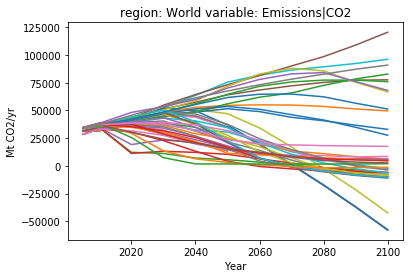

In [17]:
df.filter(variable='Emissions|CO2', region='World').line_plot(legend=False)

## Validation and diagnostic assessment of timeseries data

When analyzing scenario results, it is often useful to check whether certain timeseries exist or the values are within a specific range. For example, it may make sense to ensure that reported data for historical periods are close to established reference data or that near-term developments are reasonable.

The following section provides three illustrations:
1. Check whether a timeseries `'Primary Energy'` exists in each scenario (in at least one year).
2. Check for every scenario whether the value for `'Primary Energy'` at the global level exceeds 515 EJ/y 
   in the reference year 2010
   (the value must satisfy an upper bound of 515 EJ/y in this notation).
3. Check for every scenario from the `AMPERE` project
   whether the value for `'Primary Energy|Coal'` exceeds 400 EJ/y in mid-century.

The `validate()` function takes a `filters` dictionary to perform the checks on a selection of models/scenarios
similar to the functions introduced above.  
The ``criteria`` argument can specify a valid range by an upper and lower bound (``up``, ``lo``) for a variable and a subset of years to which the validation is applied - all scenarios with a value in at least one year outside that range are considered to *not satisfy* the validation.

By setting the argument ``exclude=True``, all scenarios failing the validation will be categorized as ``exclude`` in the metadata. This allows to remove these scenarios from subsequent analysis or figures.

In [18]:
df.require_variable(variable='Primary Energy')

INFO:root:All scenarios have the required variable `Primary Energy`


In [19]:
df.validate(criteria={'Primary Energy': {'up': 515, 'year': 2010}})

INFO:root:9 of 6622 data points to not satisfy the criteria


,model,scenario,region,variable,unit,year,value
678,AIM-Enduse 12.1,EMF27-450-Conv,World,Primary Energy,EJ/yr,2010,518.89
701,AIM-Enduse 12.1,EMF27-450-NoCCS,World,Primary Energy,EJ/yr,2010,518.81
724,AIM-Enduse 12.1,EMF27-550-LimBio,World,Primary Energy,EJ/yr,2010,518.81
747,AIM-Enduse 12.1,EMF27-Base-FullTech,World,Primary Energy,EJ/yr,2010,518.81
770,AIM-Enduse 12.1,EMF27-G8-EERE,World,Primary Energy,EJ/yr,2010,518.64
1181,REMIND 1.5,EMF27-450-Conv,World,Primary Energy,EJ/yr,2010,519.64
1202,REMIND 1.5,EMF27-450-NoCCS,World,Primary Energy,EJ/yr,2010,519.64
1223,REMIND 1.5,EMF27-550-LimBio,World,Primary Energy,EJ/yr,2010,519.64
1244,REMIND 1.5,EMF27-Base-FullTech,World,Primary Energy,EJ/yr,2010,519.64


In [20]:
pyam.validate(df, 
              filters={'region': 'World', 'scenario': 'AMPERE*'}, 
              criteria={'Primary Energy|Coal': {'up': 400, 'year': 2050}}
)

INFO:root:1 of 1566 data points to not satisfy the criteria


,model,scenario,region,variable,unit,year,value
3432,GCAM 3.0,AMPERE3-Base-EUback,World,Primary Energy|Coal,EJ/yr,2050,424.09


## Categorization of scenarios by timeseries characteristics

It is often useful to apply categorization to classes of scenarios according to specific characteristics of the timeseries data. In the following example, we use the temperature change assessment by MAGICC 6 to group scenarios by the median global warming by the end of the century (year 2100).

We proceed in the following steps:

0. Plot the timeseries data of the variable that we want to use. 
   This provides some insights on useful thresholds for the categorization.
0. Use the function ``categorize()`` to apply a categorization (and colour code for later use) 
   to all scenarios that satisfy a number of specific criteria.
0. Use the categorization of scenarios for analysis of other timeseries data.

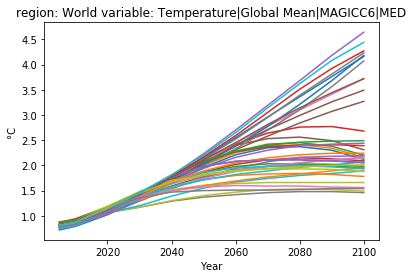

In [21]:
v = 'Temperature|Global Mean|MAGICC6|MED'
df.filter(region='World', variable=v).line_plot(legend=False)

We now use the categorization feature of the ``pyam`` package to group scenarios by temperature outcome by the end of the century.

The first cell sets the ``'Temperature'`` categorization to the default `"uncategorized"`.
This may be helpful in this tutorial if you are going back and forth between cells to reset the assignment.

The function `categorize()` takes `color` and similar arguments, which can then be used by teh plotting library.

In [22]:
df.metadata(meta='uncategorized', name='Temperature')

In [23]:
df.categorize(
    'Temperature', 'Below 1.6C',
    criteria={v: {'up': 1.6, 'year': 2100}},
    color='cornflowerblue'
)

INFO:root:4 scenarios categorized as `Temperature: Below 1.6C`


In [24]:
df.categorize(
    'Temperature', 'Below 2.0C',
    criteria={'Temperature|Global Mean|MAGICC6|MED': {'up': 2.0, 'lo': 1.6, 'year': 2100}},
    color='forestgreen'
)

INFO:root:8 scenarios categorized as `Temperature: Below 2.0C`


In [25]:
df.categorize(
    'Temperature', 'Below 2.5C',
    criteria={v: {'up': 2.5, 'lo': 2.0, 'year': 2100}},
    color='gold'
)

INFO:root:16 scenarios categorized as `Temperature: Below 2.5C`


In [26]:
df.categorize(
    'Temperature', 'Below 3.5C',
     criteria={v: {'up': 3.5, 'lo': 2.5, 'year': 2100}},
     color='firebrick'
)

INFO:root:3 scenarios categorized as `Temperature: Below 3.5C`


In [27]:
df.categorize(
    'Temperature', 'Above 3.5C',
    criteria={v: {'lo': 3.5, 'year': 2100}},
    color='magenta'
)

INFO:root:9 scenarios categorized as `Temperature: Above 3.5C`


Two models included in the snapshot have not been assessed by MAGICC6 regarding their long-term climate and warming impact. Therefore, the timeseries ``'Temperature|Global Mean|MAGICC6|MED'`` does not exist, and they have not been categorized.

In [28]:
df.require_variable(variable=v, exclude=False)

INFO:root:8 scenarios do not include required variable `Temperature|Global Mean|MAGICC6|MED`


,model,scenario
0,AIM-Enduse 12.1,EMF27-450-Conv
1,AIM-Enduse 12.1,EMF27-450-NoCCS
2,AIM-Enduse 12.1,EMF27-550-LimBio
3,AIM-Enduse 12.1,EMF27-Base-FullTech
4,AIM-Enduse 12.1,EMF27-G8-EERE
5,WITCH_EMF27,EMF27-450-Conv
6,WITCH_EMF27,EMF27-550-LimBio
7,WITCH_EMF27,EMF27-Base-FullTech


Now, we again display the median global temperature increase for all scenarios, but we use the colouring by category to illustrate the common charateristics across scenarios.

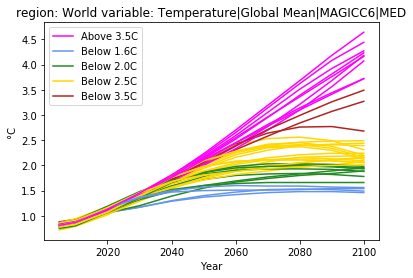

In [29]:
df.filter(variable='Temperature*').line_plot(color='Temperature', legend=True)

As a last step, we display the aggregate CO2 emissions by category. This allows to highlight alternative pathways within the same category. 

In this step, we also export this figure as a png using the option ``savefig``. The figure will be saved in the tutorials folder.

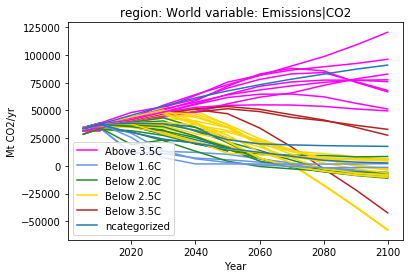

In [30]:
fig, ax = plt.subplots()
(df
 .filter(variable='Emissions|CO2', region='World')
 .line_plot(ax=ax, color='Temperature', legend=True)
)
fig.savefig('co2_emissions.png')

## Exporting timeseries data for further analysis

The IamDataFrame can be directly exported to `xlsx` and `csv` in the standard IAMC format.  
This feature is based on [pd.DataFrame.to_excel()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html) and can use any keyword arguments of that function.

In [31]:
df.to_excel('tutorial_export.xlsx')
df.export_metadata('tutorial_metadata.xlsx')